# Grey-box identification of heat transfer dynamics

Last update: 27-07-2023

---

The primary goal of this project is to identify convection effects in a grey-box model of heat transfer dynamics (see system description below), based on temperature measurements throughout the rod.

In [1]:
import Pkg
Pkg.activate("..")
Pkg.instantiate()

  Activating project at `~/syndr/Wouter/Onderzoek/Projecten/sioux/sysid-thermal/CCTA2024-BIDconvection`


## System description

A schematic depiction of the setup is shown in the figure below. 

<p><center><img src='../../system/system-photo.png'/></center></p>

In short, the setup consists of 3 metal blocks which have been lined up, with resistive nylon pads interposed. The temperature can be measured using thermistors at arbitrary places on the setup; for simplicity we assume that we measure the temperature at a single spot on each block, which we call $\tau_1$, $\tau_2$, and $\tau_3$. The temperatures will evolve due to a number of different factors; we will only consider the influence of conduction, convection, radiation, and the user controlled input heat (band heaters).

By assuming that conduction within blocks is so fast that there are no temperature differences within a block, we may model the system using a [lumped-element model](https://en.wikipedia.org/wiki/Lumped-element_model), governed by the following system of ODEs:

$$\frac{d}{dt}\begin{pmatrix} m_1 c_{p, 1} \tau_1 \\ m_2 c_{p, 2} \tau_2 \\ m_3 c_{p, 3} \tau_3 \end{pmatrix} = 
\underbrace{\begin{pmatrix} -k_{12} & k_{12} & 0 \\ k_{12} & -(k_{12} + k_{23}) & k_{23} \\ 0 & k_{23} & -k_{23} \end{pmatrix} \begin{pmatrix} \tau_1 \\ \tau_2 \\ \tau_3 \end{pmatrix}}_{\textrm{conduction}} + \underbrace{\begin{pmatrix} h(\tau_1, \tau_a, 1, t) \\ h(\tau_2, \tau_a, 2, t) \\ h(\tau_3, \tau_a, 3, t) \end{pmatrix}}_{\textrm{convection}} + \underbrace{\sigma \begin{pmatrix} a_1 \varepsilon_1 (\tau_a^4 - \tau_1^4) \\ a_2 \varepsilon_2 (\tau_a^4 - \tau_2^4) \\ a_3 \varepsilon_3 (\tau_a^4 - \tau_3^4) \end{pmatrix}}_{\textrm{radiation}} + \underbrace{\begin{pmatrix} u_1 \\ u_2 \\ u_3 \end{pmatrix}}_{\textrm{input}}.$$

Convection is notoriously hard to model. A coarse approximation would be Newton's law of cooling (Clercx, 2015; Eq. 8.17), which states that convection is linear in the difference between the temperature of the block and the ambient temperature: $h_a (\tau_a - \tau_i)$. With this linear term, we can take steps similar to the identification of the oscillator in Rogers \& Friis (2022), describing the nonlinear function as the combination of a linear term and a "nonlinear remainder":

$$\underbrace{h(\tau_i, \tau_a, i, t)}_{\text{total convection}} = \underbrace{h_a (\tau_a - \tau_i)}_{\text{linear cooling law}} + \underbrace{r(\tau_i, \tau_a, i, t)}_{\text{nonlinear remainder}} \, ,$$

for some constant $h_a$. Furthermore, the role of radiation can often be neglected. With these simplifications, our governing equations become:

$$\frac{d}{dt}\begin{pmatrix} m_1 c_{p, 1} \tau_1 \\ m_2 c_{p, 2} \tau_2 \\ m_3 c_{p, 3} \tau_3 \end{pmatrix} = 
\begin{pmatrix} -k_{12} & k_{12} & 0 \\ k_{12} & -(k_{12} + k_{23}) & k_{23} \\ 0 & k_{23} & -k_{23} \end{pmatrix} \begin{pmatrix} \tau_1 \\ \tau_2 \\ \tau_3 \end{pmatrix} + h_a \begin{pmatrix} a_1 (\tau_a - \tau_1) \\ a_2 (\tau_a - \tau_2) \\ a_3 (\tau_a - \tau_3) \end{pmatrix} + \begin{pmatrix} r(\tau_1, \tau_a, 1, t) \\ r(\tau_2, \tau_a, 2, t) \\ r(\tau_3, \tau_a, 3, t) \end{pmatrix} + \begin{pmatrix} u_1 \\ u_2 \\ u_3 \end{pmatrix},$$

or, more compactly, 

$$ M \dot{z} = K z + h_a a (\tau_a - z) + r(z,\tau_a) + u$$

where $z = [\tau_1 \, , \ \tau_2 \, , \ \tau_3]$.

In these equations, we can distinguish three types of quantities:
1. Measured/observed quantities: e.g. $\tau_i$, $u_i$. These may vary over time, and are known up to a given accuracy due to measurement noise;

2. Known constants: e.g. $m_i$, $c_{p, i}$, $a$, $\tau_a$. These are fully known, and are constant over time. This is reasonable for quantities such as mass $m$ and surface area $a$ (which can be easily measured) and specific heat capacity $c_p$ (which is a material property which according to the Dulong-Petit Law is roughly constant for metals over a long range of temperatures Carter (2000), Ch. 16) Maybe it is less reasonable for the ambient temperature $\tau_a$ (due to e.g. the setup heating up its surroundings);

3. Unknown constants: e.g. $k_{ij}$, $h_a$. These are not known a priori, because there is no simple physical way to measure or derive their values. For example, the conduction coefficients $k_{ij}$ can vary depending on how tightly the blocks have been put together. In this project, we want to identify these constants using Bayesian inference.

In [1]:
using Revise
using DifferentialEquations
using GaussianProcesses
using Distributions
using ForwardDiff
using LaTeXStrings
using LinearAlgebra
using MAT
using Optim
using Polynomials
using Random
using RxInfer

using Plots; default(label="", linewidth=3, margin=15Plots.pt)
include("../util/discretization.jl");

## Data simulation

In [2]:
# Time parameters
T = 300
Δt = 2.0
tsteps = range(0.0, step=Δt, length=T)

# Constants
true_mcp_1 = 1e3
true_mcp_2 = 1e3
true_mcp_3 = 1e3
true_a_1 = 1.0
true_a_2 = 1.0
true_a_3 = 1.0
true_k12 = 100.
true_k23 = 50.
true_h_a = 20.0
true_τ_a = 19.
true_R   = 1e-2*diagm(ones(3))

# Input heat parameters
true_b = [750.0, 0., 0.]

3-element Vector{Float64}:
 750.0
   0.0
   0.0

In [21]:
# Temperature inputs
τr = range(10, stop=40, step=0.1)
NN = length(τr)

# Kernel hyperparameters
l_true = 1500
λ_true = sqrt(3)/l_true
γ_true = 1e3

# Kernel
κ(τ,τ_prime) = γ_true^2 .*exp.(-λ_true.*abs.(τ - τ_prime))
K = zeros(NN,NN)
for ii in 1:NN
    for jj in 1:NN
        K[ii,jj] = κ(τr[ii], τr[jj])
    end
end

# Inverse of kernel
Ki = inv(K + 0.0*diagm(ones(NN)))

# Generate targets for Gaussian Process
# r(z,i,τ_a) = min(0,((τ_a - (10-2i) -z[1])^3)./2)
# r(z,i,τ_a) = min(0,((τ_a - z)^3)./i)
r(z,i,τ_a) = min(0,(τ_a - z)^3)
targets1 = r.(τr, 1, true_τ_a) 
targets2 = r.(τr, 2, true_τ_a) 
targets3 = r.(τr, 3, true_τ_a) 

# GP Predictive distribution
pred_mean_block1(τ) = dot(κ.(τ,τr), Ki*targets1)
pred_mean_block2(τ) = dot(κ.(τ,τr), Ki*targets2)
pred_mean_block3(τ) = dot(κ.(τ,τr), Ki*targets3)

pred_mean_block3 (generic function with 1 method)

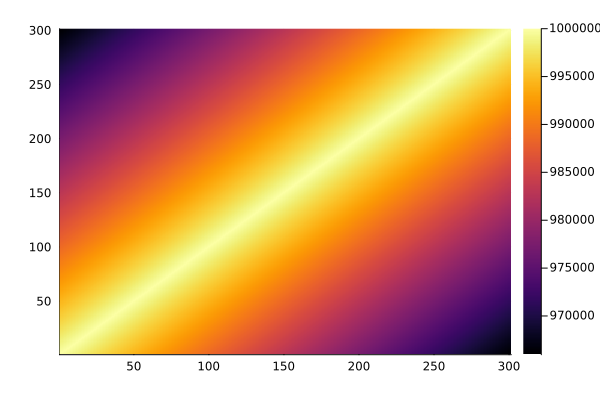

In [22]:
heatmap(K)

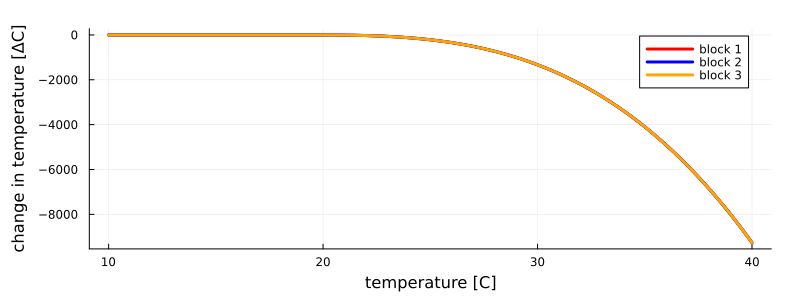

In [23]:
# Simulate nonlinear convection function
dτr1 = pred_mean_block1.(τr)
dτr2 = pred_mean_block2.(τr)
dτr3 = pred_mean_block3.(τr)

plot(xlabel="temperature [C]", ylabel="change in temperature [ΔC]", size=(800,300))
plot!(τr, dτr1, color="red", label="block 1")
plot!(τr, dτr2, color="blue", label="block 2")
plot!(τr, dτr3, color="orange", label="block 3")

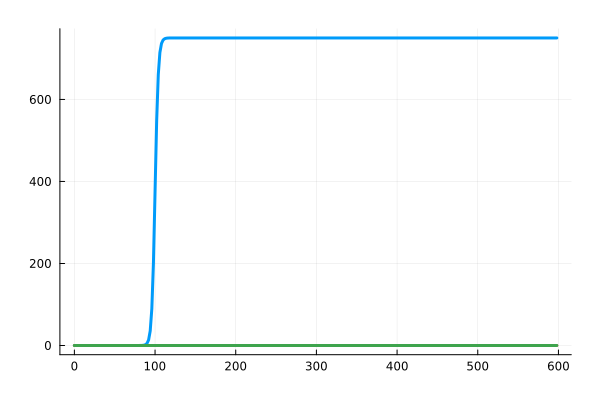

In [24]:
function u(t::Float64, b::Float64; i::Int64=1) 
    "Constant heater"
    return b
end

function u(t::Float64, b::Float64, t_on::Float64; i::Int64=1, β::Float64=0.1) 
    "Turn on heater"
    return b ./(1+exp(-β*(t - t_on))) 
end

function u(t::Float64; i::Int64=1, b::Float64=1.0, t_on::Float64=20., t_off::Float64=60., β1::Float64=0.6, β2::Float64=0.4) 
    "Pulse heater"
    return b ./(1+exp(-β1*(t - t_on))) * exp(-β2*(t - t_off))./(1+exp(-β2*(t - t_off)))
end

t_onset = 100.
β = 0.5

# Generate functions
u1(t) = u.(t, true_b[1], t_onset, i=1, β=β)
u2(t) = u.(t, true_b[2], t_onset, i=2, β=β)
u3(t) = u.(t, true_b[3], t_onset, i=3, β=β)
  
inputs = hcat([[u1(k); u2(k); u3(k)] for k in tsteps]...)

plot(tsteps, inputs')

In [25]:
function NONLCONV(dz, z, params, t)
    "Lumped-element model with nonlinear convection term"

    # Extract parameters
    mcp_1, mcp_2, mcp_3, a_1, a_2, a_3, τ_a, k12, k23, h_a = params
    
    # Conduction
    dz[1] = (-k12*z[1] +      k12 *z[2]            ) / mcp_1
    dz[2] = ( k12*z[1] - (k12+k23)*z[2] + k23 *z[3]) / mcp_2
    dz[3] = (                 k23 *z[2] - k23 *z[3]) / mcp_3
    
    # Convection - linear
    dz[1] += h_a * a_1 * (τ_a - z[1]) / mcp_1
    dz[2] += h_a * a_2 * (τ_a - z[2]) / mcp_2
    dz[3] += h_a * a_3 * (τ_a - z[3]) / mcp_3 
    
    # Convection - nonlinear
    dz[1] += pred_mean_block1(z[1]) / mcp_1
    dz[2] += pred_mean_block2(z[2]) / mcp_2
    dz[3] += pred_mean_block3(z[3]) / mcp_3
    
    # Input heat
    dz[1] += u1(t) / mcp_1
    dz[2] += u2(t) / mcp_2
    dz[3] += u3(t) / mcp_3
end

NONLCONV (generic function with 1 method)

In [26]:
sysparams = [true_mcp_1, 
             true_mcp_2, 
             true_mcp_3, 
             true_a_1, 
             true_a_2, 
             true_a_3,
             true_τ_a, 
             true_k12, 
             true_k23, 
             true_h_a]

τ_0 = [24., 24., 24.]

# Solve the system numerically using DifferentialEquations.jl
sys_NONLCONV = ODEProblem(NONLCONV, τ_0, (tsteps[1], tsteps[end]), sysparams)
states = Array(solve(sys_NONLCONV, RK4(); saveat=tsteps, verbose = true))

3×300 Matrix{Float64}:
 24.0  23.5885  23.2402  22.9401  …  26.0483  26.0483  26.0488  26.0492
 24.0  23.5885  23.2402  22.9401     23.4644  23.4645  23.464   23.4637
 24.0  23.5885  23.2402  22.9401     21.8551  21.8551  21.8551  21.8552

In [27]:
# Noisy measurements
measurements = zeros(3,T)
for k = 1:T
    measurements[:,k] = states[:,k] + cholesky(true_R).L*randn(3)
end

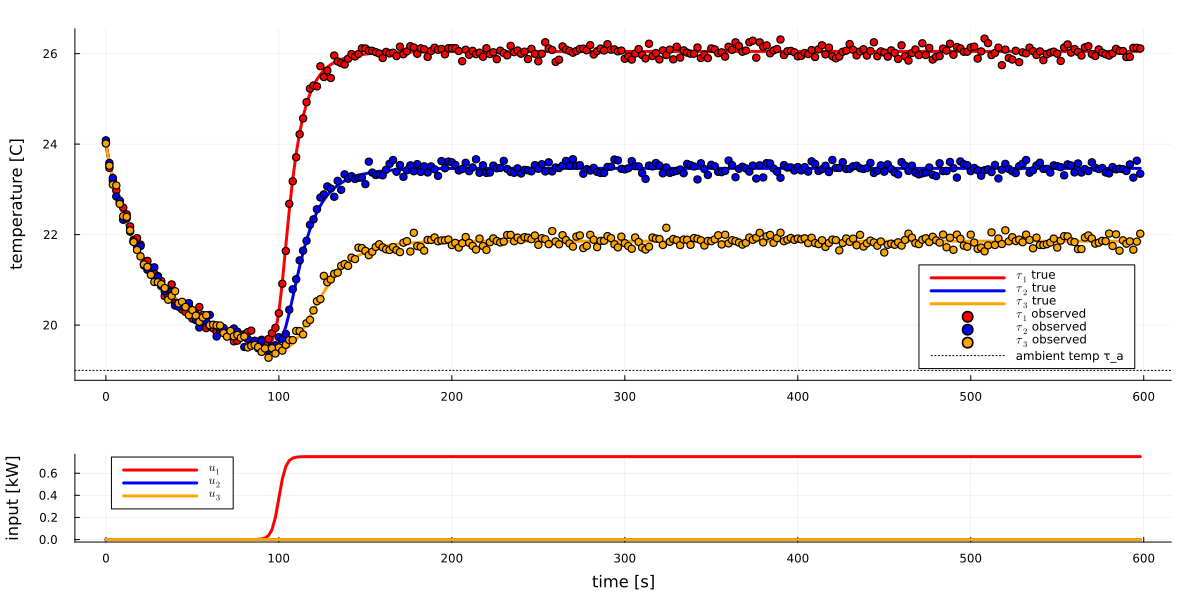

In [28]:
p101 = plot(xlabel="", ylabel="temperature [C]")
plot!(tsteps, states', linecolors = ["red" "blue" "orange"], labels = [L"$τ_1$ true" L"$τ_2$ true" L"$τ_3$ true"], )
scatter!(tsteps, measurements', markercolors = ["red" "blue" "orange"], labels = [L"$τ_1$ observed" L"$τ_2$ observed" L"$τ_3$ observed"])
hline!([true_τ_a], color="black", linewidth=1, linestyle=:dot, label="ambient temp τ_a")

p102 = plot(xlabel = "time [s]", ylabel = "input [kW]")
plot!(tsteps, inputs' ./ 1000, linecolors = ["red" "blue" "orange"], labels = [L"$u_1$" L"$u_2$" L"$u_3$"], )

plot(p101, p102, layout=grid(2,1, heights=[0.8, 0.2]), size=(1200,600))

In [29]:
output_ = [measurements[:,k] for k in 1:T];
inputs_ = [[true_τ_a; inputs[:,k]] for k in 1:T];

In [31]:
@model function SSM(A, B, C, Q, R, m0, S0; T=1)
    
    x = randomvar(T)
    u = datavar(Vector{Float64}, T)
    y = datavar(Vector{Float64}, T)
    
    x_0 ~ MvNormalMeanCovariance(m0, S0)
    x_kmin1 = x_0
    for k = 1:T
        
        x[k] ~ MvNormalMeanCovariance(A*x_kmin1 + B*u[k], Q)
        y[k] ~ MvNormalMeanCovariance(C*x[k], R)
        
        x_kmin1 = x[k]
    end
end

In [32]:
Dx = 3
Du = 4
Dy = 3

M  = [true_mcp_1          0           0;
     0           true_mcp_2           0;
     0                    0  true_mcp_3]
K  = [-true_k12       true_k12                0;
       true_k12  -(true_k12+true_k23)  true_k23;
              0       true_k23        -true_k23]
An = [true_a_1, true_a_2, true_a_3]

F  = inv(M)*(K - true_h_a*diagm(An))
G  = inv(M)*[true_h_a*An diagm(ones(Dx))]

λ_star = λ_true
γ_star = γ_true

A  = exp(F*Δt)
B  = G*Δt
C  = diagm(ones(Dy))
Q  = 1e-8*diagm(ones(Dx))
R  = true_R*diagm(ones(Dy))

m0 = 21*ones(Dx)
S0 = 1e3*diagm(ones(Dx))

results = inference(
    model       = SSM(A, B, C, Q, R, m0, S0, T=T),
    data        = (y = output_, u = inputs_),
    options     = (limit_stack_depth = 100,),
    free_energy = true,
)

Inference results:
  Posteriors       | available for (x_0, x)
  Free Energy:     | Real[2.23338e6]


In [33]:
qx = results.posteriors[:x]
fitx_v = cat( var.(qx)..., dims=2)
fitx_m = cat(mean.(qx)..., dims=2)

3×300 Matrix{Float64}:
 21.9269  21.8334  21.74    21.6485  …  36.6306  36.6308  36.6309  36.631
 21.9712  21.8547  21.7484  21.6497     31.6203  31.6204  31.6205  31.6207
 21.8659  21.7773  21.69    21.6046     28.1405  28.1407  28.1408  28.1409

In [34]:
FMSE_GPSSM = mean((fitx_m - states).^2)
println("Filtered MSE states and fit: $FMSE_GPSSM")

Filtered MSE states and fit: 49.571842168109534


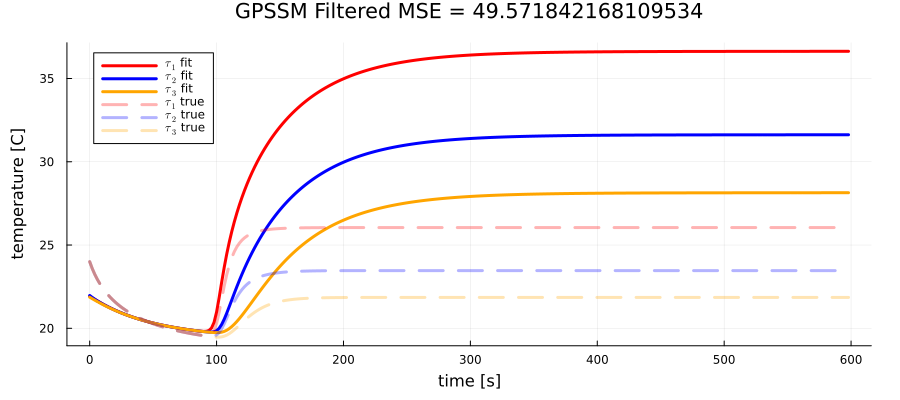

In [35]:
plot(tsteps,
     fitx_m';
     ribbon=sqrt.(fitx_v)',
     legend = true, 
     title="GPSSM Filtered MSE = $FMSE_GPSSM",
     linecolors = ["red" "blue" "orange"], 
     fillcolors = ["red" "blue" "orange"], 
     labels = [L"$τ_1$ fit" L"$τ_2$ fit" L"$τ_3$ fit"],
     xlabel = "time [s]", 
     ylabel = "temperature [C]",
     size=(900,400)
)
plot!(tsteps, 
      transpose(states), 
      alpha = 0.3,
      linecolors = ["red" "blue" "orange"], 
      linestyle = :dash,
      labels = [L"$τ_1$ true" L"$τ_2$ true" L"$τ_3$ true"],
)


### Fit GP to residuals

In [37]:
# Post-measurement residuals
residuals = measurements - C*fitx_m

# Fit GP 
gp1 = GP(tsteps, residuals[1,:], MeanZero(), Mat12Iso(1., 1.), log(sqrt(R[1,1])))
gp2 = GP(tsteps, residuals[2,:], MeanZero(), Mat12Iso(1., 1.), log(sqrt(R[2,2])))
gp3 = GP(tsteps, residuals[3,:], MeanZero(), Mat12Iso(1., 1.), log(sqrt(R[3,3])))

GP Exact object:
  Dim = 1
  Number of observations = 300
  Mean function:
    Type: MeanZero, Params: Float64[]
  Kernel:
    Type: Mat12Iso{Float64}, Params: [1.0, 1.0]
  Input observations = 
[0.0 2.0 … 596.0 598.0]
  Output observations = [2.148323496656616, 1.7455855096465598, 1.4152428353785673, 1.483226410866159, 1.1581300845784703, 0.9667392363922609, 1.0295905885136811, 0.8063607290907946, 0.6211918966559757, 0.5164776180421633  …  -6.116352404166122, -6.3907656666621335, -6.134193376177819, -6.495009831280502, -6.266390030942986, -6.340530481715657, -6.289678699743266, -6.473864568588059, -6.295070372464306, -6.120526835754131]
  Variance of observation noise = 0.010000000000000004
  Marginal Log-Likelihood = -723.286

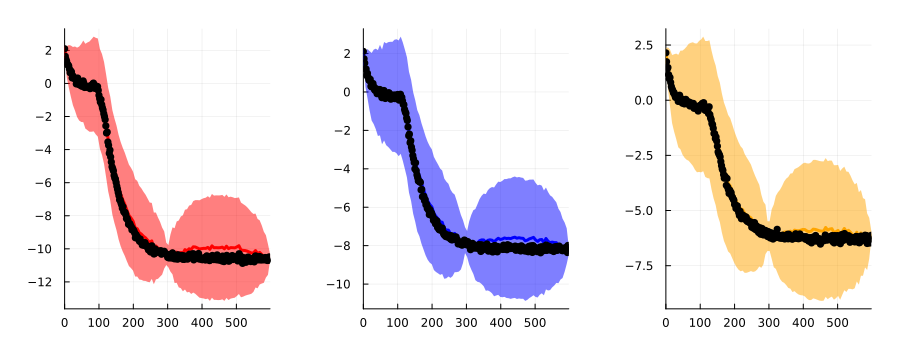

In [42]:
p1 = plot(gp1, color="red", fillcolor="red")
p2 = plot(gp2, color="blue", fillcolor="blue")
p3 = plot(gp3, color="orange", fillcolor="orange")
plot(p1,p2,p3, layout=(1,3), size=(900,350))

## Model validation

### Simulation with true function to generate validation data

In [37]:
N_val = 1000
tsteps_val = range(0.0, step=Δt, length=N_val)

t_onset_val = 30.
β = 0.5

# Generate functions
u1_val(t) = u.(t, true_b[1], t_onset_val, i=1, β=β)
u2_val(t) = u.(t, true_b[2], t_onset_val, i=2, β=β)
u3_val(t) = u.(t, true_b[3], t_onset_val, i=3, β=β)

inputs_val = hcat([[u1_val(k); u2_val(k); u3_val(k)] for k in tsteps_val]...)

3×1000 Matrix{Float64}:
 0.000917707  0.000964758  0.00101422  …  3000.0  3000.0  3000.0  3000.0
 0.0          0.0          0.0               0.0     0.0     0.0     0.0
 0.0          0.0          0.0               0.0     0.0     0.0     0.0

In [38]:
function NONLCONV_val(dz, z, params, t)
    "Lumped-element model with nonlinear convection term"

    # Extract parameters
    mcp_1, mcp_2, mcp_3, a_1, a_2, a_3, τ_a, k12, k23, h_a = params
    
    # Conduction
    dz[1] = (-k12*z[1] +      k12 *z[2]            ) / mcp_1
    dz[2] = ( k12*z[1] - (k12+k23)*z[2] + k23 *z[3]) / mcp_2
    dz[3] = (                 k23 *z[2] - k23 *z[3]) / mcp_3
    
    # Convection - linear
    dz[1] += h_a * a_1 * (τ_a - z[1]) / mcp_1
    dz[2] += h_a * a_2 * (τ_a - z[2]) / mcp_2
    dz[3] += h_a * a_3 * (τ_a - z[3]) / mcp_3
    
    # Convection - nonlinear
    dz[1] += pred_mean_block1(z[1]) ./ mcp_1
    dz[2] += pred_mean_block2(z[2]) ./ mcp_2
    dz[3] += pred_mean_block3(z[3]) ./ mcp_3
    
    # Input heat
    dz[1] += u1_val(t) / mcp_1
    dz[2] += u2_val(t) / mcp_2
    dz[3] += u3_val(t) / mcp_3
end

NONLCONV_val (generic function with 1 method)

In [39]:
sysparams = [true_mcp_1, 
             true_mcp_2, 
             true_mcp_3, 
             true_a_1, 
             true_a_2, 
             true_a_3, 
             true_τ_a, 
             true_k12, 
             true_k23, 
             true_h_a]

τ0_val = [20., 20.5, 21.]
sys_NONLCONV = ODEProblem(NONLCONV_val, τ0_val, (tsteps_val[1], tsteps_val[end]), sysparams)
states_val = Array(solve(sys_NONLCONV, RK4(); saveat=tsteps_val, verbose = true))

measurements_val = states_val + cholesky(true_R).L*randn(size(states_val))

3×1000 Matrix{Float64}:
 20.0658  19.9751  20.011   19.8902  …  29.7527  30.0372  29.6848  29.9671
 20.4018  20.5667  20.4245  20.6294     24.3862  24.28    24.3397  24.4125
 21.0075  21.0657  21.1395  21.0606     22.6766  22.3978  22.392   22.3795

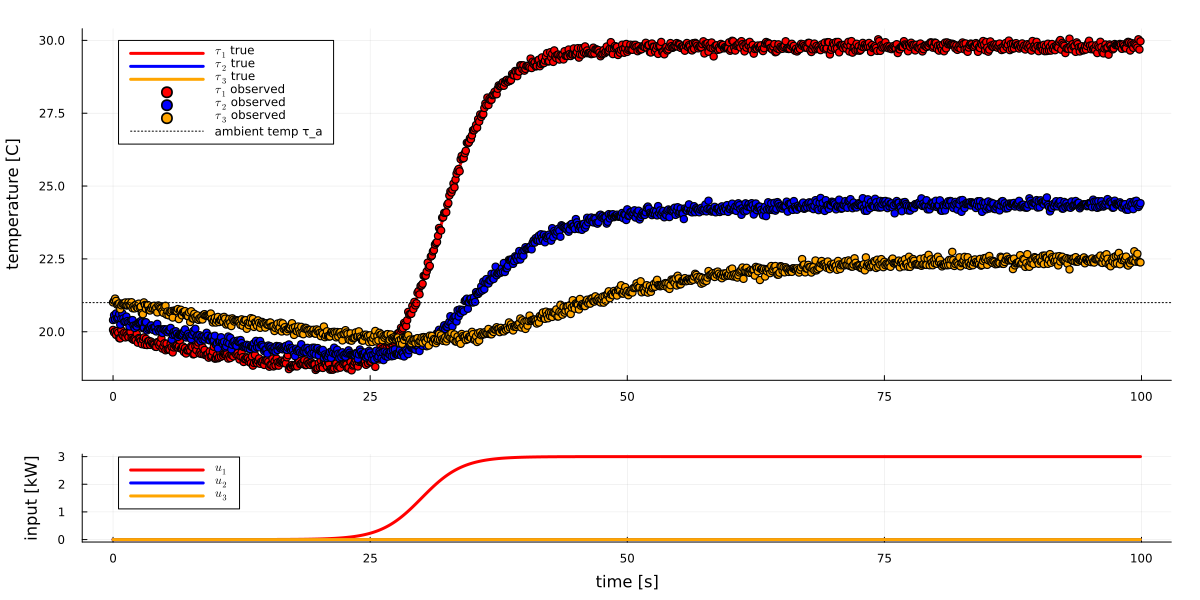

In [40]:
p101 = plot(xlabel="", ylabel="temperature [C]")
plot!(tsteps_val, states_val', linecolors = ["red" "blue" "orange"], labels = [L"$τ_1$ true" L"$τ_2$ true" L"$τ_3$ true"], )
scatter!(tsteps_val, measurements_val', markercolors = ["red" "blue" "orange"], labels = [L"$τ_1$ observed" L"$τ_2$ observed" L"$τ_3$ observed"])
hline!([true_τ_a], color="black", linewidth=1, linestyle=:dot, label="ambient temp τ_a")

p102 = plot(xlabel = "time [s]", ylabel = "input [kW]")
plot!(tsteps_val, inputs_val' ./ 1000, linecolors = ["red" "blue" "orange"], labels = [L"$u_1$" L"$u_2$" L"$u_3$"], )

plot(p101, p102, layout=grid(2,1, heights=[0.8, 0.2]), size=(1200,600))

### Simulation by identified model

In [41]:
function NONLCONV_idsim(dz, z, params, t)
    "Lumped-element model with nonlinear convection term"

    # Extract parameters
    mcp_1, mcp_2, mcp_3, a_1, a_2, a_3, τ_a, k12, k23, h_a = params
    
    # Conduction
    dz[1] = (-k12*z[1] +      k12 *z[2]            ) / mcp_1
    dz[2] = ( k12*z[1] - (k12+k23)*z[2] + k23 *z[3]) / mcp_2
    dz[3] = (                 k23 *z[2] - k23 *z[3]) / mcp_3
    
    # Convection - linear
    dz[1] += h_a * a_1 * (τ_a - z[1]) / mcp_1
    dz[2] += h_a * a_2 * (τ_a - z[2]) / mcp_2
    dz[3] += h_a * a_3 * (τ_a - z[3]) / mcp_3
    
    # Convection - nonlinear
    dz[1] += f1_pol3(z[1]) ./ mcp_1
    dz[2] += f2_pol3(z[2]) ./ mcp_2
    dz[3] += f3_pol3(z[3]) ./ mcp_3
    
    # Input heat
    dz[1] += u1_val(t) / mcp_1
    dz[2] += u2_val(t) / mcp_2
    dz[3] += u3_val(t) / mcp_3
end

idNONLCONV = ODEProblem(NONLCONV_idsim, τ0_val, (tsteps_val[1], tsteps_val[end]), sysparams)
sim_states = Array(solve(idNONLCONV, Tsit5(); saveat=tsteps_val, verbose = true))

3×1000 Matrix{Float64}:
 20.0  19.9862  19.9726  19.9593  …  29.7863  29.7866  29.7869  29.7872
 20.5  20.4901  20.4803  20.4705     24.4424  24.4423  24.4423  24.4422
 21.0  20.9945  20.989   20.9835     22.4376  22.4377  22.4378  22.4379

### Compare true and identified 

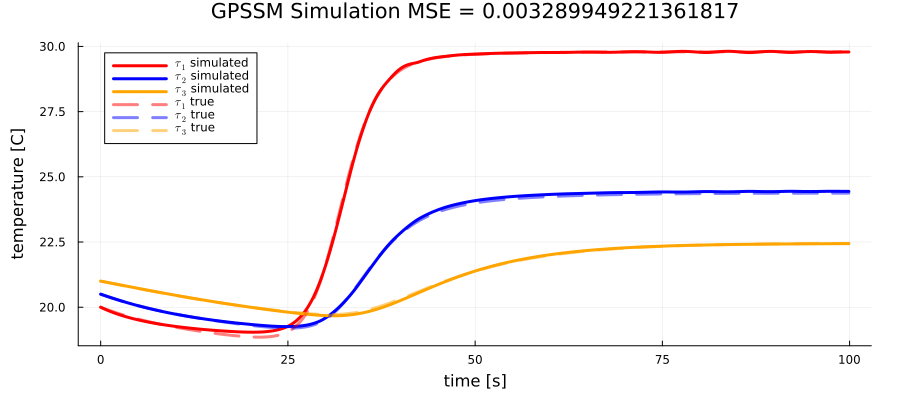

In [42]:
SMSE_GPSSM = mean((sim_states - states_val).^2)

plot(tsteps_val,
     sim_states';
     legend = true, 
     title = "GPSSM Simulation MSE = $SMSE_GPSSM",
     linecolors = ["red" "blue" "orange"], 
     fillcolors = ["red" "blue" "orange"], 
     labels = [L"$τ_1$ simulated" L"$τ_2$ simulated" L"$τ_3$ simulated"],
     xlabel = "time [s]", 
     ylabel = "temperature [C]",
     size=(900,400)
)
plot!(tsteps_val, 
      transpose(states_val), 
      alpha = 0.5,
      linecolors = ["red" "blue" "orange"], 
      linestyle = :dash,
      labels = [L"$τ_1$ true" L"$τ_2$ true" L"$τ_3$ true"],
)


In [43]:
savefig("figures/NONLCONV_VL+GPASSM-simulations.png")

"/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/sioux/sysid-thermal/CCTA2024-BIDconvection/experiment-simulated/figures/NONLCONV_VL+GPASSM-simulations.png"